### IMBalance to Balance

observation in one class is higher than the observation in other classes then there exists a class imbalance.

-Random under-sampling

-Random over-sampling

In [2]:
dbutils.library.installPyPI("scikit-learn", version="0.23.2" )
dbutils.library.installPyPI("imbalanced-learn")

Out[1]: True

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass

In [5]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [7]:
from pyspark.sql.functions import col, format_string, to_date, when

base_path = "/mnt/nl-wl-data-sandbox-recent/"
file_name = "rcent_MODEl_v2.csv"

def read_csv(base_path, file_name):
  file_path = "%s/%s" % (base_path, file_name)
  df = spark.read.csv(file_path, header=True, inferSchema=True)\
    .withColumn("cust_nr", format_string("%08d", "klant_nr"))\
    .withColumn("datum", to_date("datum", "dd-MM-yyyy"))\
    .withColumn("target", when(col("gb_def")=='Good', 0).otherwise(1))\
    .drop("cust_id","order","date")
  
  return df

df = read_csv(base_path, file_name)


In [1]:
# Convert spark dataframe to pandas dataframe
df = df.toPandas()
df.head()

NameError: name 'df' is not defined

In [2]:
#shows the missing values at individual variable level

#df.isnull().sum() --> works same as below code
df.apply(lambda x: sum(x.isnull()), axis=0)

NameError: name 'df' is not defined

In [10]:
#shows the total number of missing values
df.isnull().sum().sum()

Out[9]: 53016

In [11]:
#variables which we can remove
var_null_pc = df.isnull().sum(axis=0).sort_values( ascending=False)/float(len(df) )
var_null_pc[ var_null_pc > 0.75 ]

Out[10]: Series([], dtype: float64)

In [3]:

df.drop( var_null_pc[ var_null_pc > 0.75 ].index, axis = 1,  ) 
df.dropna( axis = 0, thresh = 30, )

NameError: name 'df' is not defined

In [13]:
#Fillna method for Replacing with Mean Value
df.fillna(df.median(), inplace= True)

In [14]:
#Converting data type of float  columns 
cols=['cust_nr',  'ordervalue']
df[cols] = df[cols].applymap(np.int32)

In [4]:
df.dtypes


NameError: name 'df' is not defined

In [5]:
df.columns

NameError: name 'df' is not defined

In [17]:
#df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
#df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
df.dtypes


NameError: name 'df' is not defined

In [7]:
##Use corr() function to find the correlation among the columns in the dataframe using ‘Pearson’ method.
df.corr(method = 'pearson')

NameError: name 'df' is not defined

In [9]:
import pandas as pd

def show_missing_values(df):
  missing = df.isnull().sum()
  percent = 100 * (missing / len(df))
  df = pd.concat([missing, percent], axis=1)
  df = df.rename(columns={0: "aantal", 1: "%"})
  return df.drop(['cust_nr','datum','ORDER','target'])

show_missing_values(df)

NameError: name 'df' is not defined

In [21]:
# drop( ) function is used to remove column(s).axis=1 tells  that you want to apply function on columns instead of rows
df.drop(['date','cust_nr', 'ORDER'], axis = 1, inplace= True)


In [22]:
#Target columns
target = 'target'

In [23]:
#use to select rows and columns by the order in which they appear in the data frame NOT equal to target
X = df.loc[:, df.columns!=target]

In [24]:
#use to select rows and columns by the order in which they appear in the data frame
Y = df.loc[:, df.columns==target]

In [25]:
#spliting the dataset into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.20, 
                                                    random_state=42)

In [26]:
# Draw Seaborn Scatter Plot to find target class
ax = sns.countplot(x=target, data=df)
print(df[target].value_counts())


0 959537
1 22894
Name: target, dtype: int64

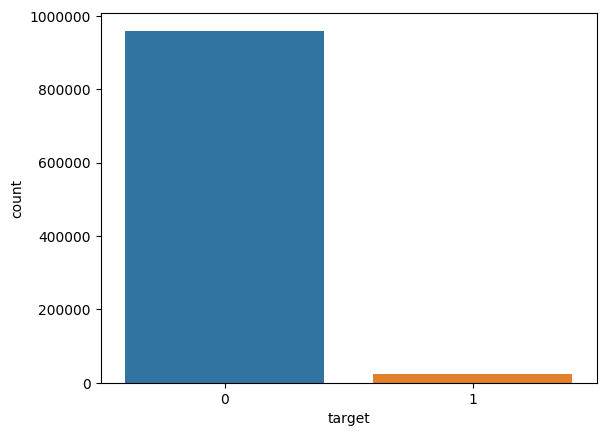

In [27]:
# visualize the target variable
display(plt.show())

In [28]:
 # Target class 1
  100* (22894/float(df.shape[0]))

File "<command-150567>" , line 2 
 100* (22894/float(df.shape[0])) 
 ^
 IndentationError : unexpected indent

In [29]:
# Target class 0
100* (959537/float(df.shape[0]))

Out[29]: 97.66965822536137

In [30]:
#Y train Target value counts
Y_train[target].value_counts()

In [31]:
#LogisticRegression
clf = LogisticRegression().fit(X_train, Y_train)

/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)

In [32]:
Y_Test_Pred = clf.predict(X_test)

In [33]:
# simple cross-tabulation of two (or more) factors
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(Y_test[target], name = 'Actual'))

Actual,0,1
Predicted,,
0,38444,836


In [34]:
#Model Report
generate_model_report(Y_test, Y_Test_Pred)

Accuracy = 0.976675301673902
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
Precision = 0.0
Recall = 0.0
F1 Score = 0.0

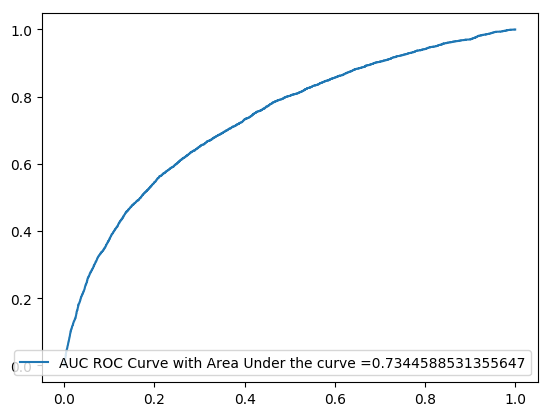

In [35]:
#AUC ROC Curve
display(generate_auc_roc_curve(clf, X_test))


In [36]:

unique_classes = list(df[target].unique())
unique_classes

Out[38]: [0, 1]

In [37]:
out_dict = {}
for classes in unique_classes:
    out_dict[classes] = df.shape[0]/((df.loc[df[target] == classes].shape[0])
                                     *len(unique_classes))

In [38]:
out_dict

Out[41]: {0: 0.5119297119339848, 1: 21.456080195684457}

In [39]:
print (X_train.shape, Y_train.shape)

(785944, 9) (785944, 1)

In [40]:
clf = LogisticRegression(class_weight='balanced').fit(X_train, Y_train)

/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

In [41]:
from sklearn.utils import class_weight

In [42]:
class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train[target])

/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=896567 0
942959 0
347857 0
288379 0
555383 0
19454 0
732681 0
114087 0
490617 0
961282 0
677165 0
814149 0
318555 0
78219 0
784976 0
253410 0
835449 0
54210 0
459906 0
546674 0
770165 0
535886 0
639141 0
511822 0
136396 0
82561 0
714610 0
906722 0
438847 0
83685 0
 ..
235796 0
103355 0
791743 0
199041 0
776997 0
327069 0
718315 0
321879 0
787201 0
64820 0
329365 0
41090 0
278167 0
191335 0
175203 0
912756 0
899159 0
87498 0
954698 0
521430 0
137337 0
54886 0
732180 0
110268 0
644167 0
259178 0
365838 0
131932 0
671155 0
121958 0
Name: target, Length: 785944, dtype: int32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
 FutureWarning)
Out[45]: array([ 0.51192692, 21.46097974])

In [43]:
Y_Test_Pred = clf.predict(X_test)

In [44]:
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(Y_test[target], name = 'Actual'))

Actual,0,1
Predicted,,
0,28557,612
1,9887,224


##### Based on the confusion matrix we can measure the following:

Precision: True Positives / All Predicted Positives = TP / (TP+FP). Precision is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

Recall: True Positives / All actual positives = TP / (TP + FN). Recall is a measure of a classifier’s completeness. It is also the same as Sensitivity or the True positive rate. Low recall indicates a high number of false negatives.

F1 score: 2TP/(2TP + FP + FN) A weighted average of precision and recall. If we wanted a balance between precision and recall then we’d look at F1 score.

In [46]:
generate_model_report(Y_test, Y_Test_Pred)

Accuracy = 0.7439728837022297
Precision = 0.05170892405435614
Recall = 0.5753873008946105
F1 Score = 0.09489024829075207

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes.

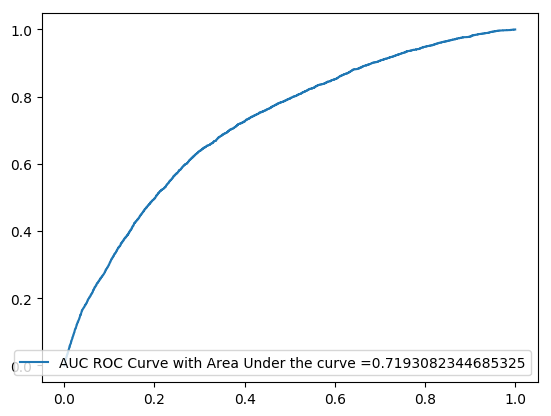

In [48]:
display(generate_auc_roc_curve(clf, X_test))

In [49]:
 #Explore the effect of weighting on F1 score 
weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)

grid_result = gsc.fit(X_train, Y_train)
print("Best parameters : %s" % grid_result.best_params_)

/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

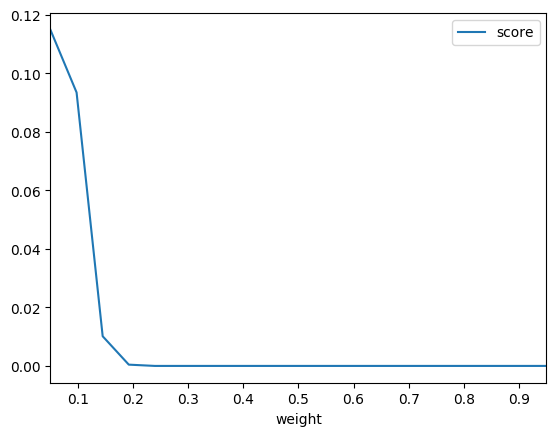

In [50]:
#Effect of weighting on F1 score to figure 
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
display(data_out.plot(x='weight').figure)

In [51]:
#Score vs Weight
data_out

,score,weight
0,0.114811,0.050000
1,0.093440,0.097368
2,0.010137,0.144737
3,0.000436,0.192105
4,0.000000,0.239474
5,0.000000,0.286842
6,0.000000,0.334211
7,0.000000,0.381579
8,0.000000,0.428947
9,0.000000,0.476316


In [52]:
#Log REG Undersampling
clf = LogisticRegression(**grid_result.best_params_).fit(X_train, Y_train)

/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

In [53]:
Y_Test_Pred = clf.predict(X_test)

In [54]:
# Actual and Predicted a simple cross-tabulation
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(Y_test[target], name = 'Actual'))

Actual,0,1
Predicted,,
0,35973,773
1,2471,63


In [55]:
#Model Report 
generate_model_report(Y_test, Y_Test_Pred)

Accuracy = 0.923022897189127
Precision = 0.07723772858517805
Recall = 0.21012437268164957
F1 Score = 0.11295525189138468

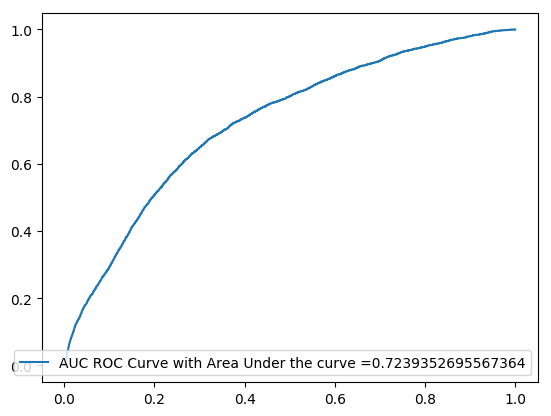

In [56]:
display(generate_auc_roc_curve(clf, X_test))

In [57]:
unique, count = np.unique(Y_train, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

Out[59]: {0: 767633, 1: 18311}

In [58]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

In [59]:
unique, count = np.unique(y_train_res, return_counts=True)
Y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_smote_value_count

Out[61]: {0: 767633, 1: 767633}

In [60]:
clf = LogisticRegression().fit(x_train_res, y_train_res)

/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

In [61]:
Y_Test_Pred = clf.predict(X_test)

In [62]:
# Actual and Predicted a simple cross-tabulation Over sampling
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(Y_test[target], name = 'Actual'))

Actual,0,1
Predicted,,
0,24832,542
1,13612,294


In [63]:
generate_model_report(Y_test, Y_Test_Pred)

Accuracy = 0.6534630789823246
Precision = 0.04530679458724136
Recall = 0.6903774819986909
F1 Score = 0.08503319089467602

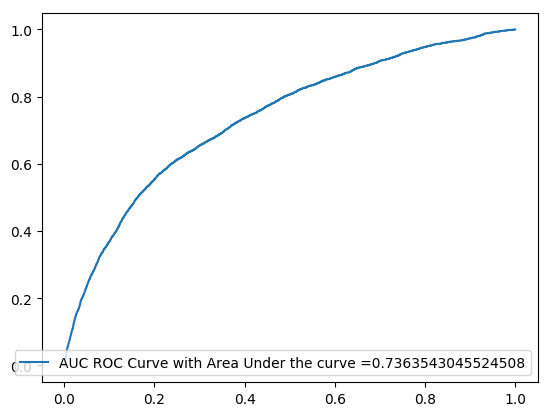

In [64]:
#Smote Over smapling AUC ROC
display(generate_auc_roc_curve(clf, X_test))

In [65]:
# compute and adjust weights
weights = np.linspace(0.005, 0.25, 10)
weights

Out[67]: array([0.005 , 0.03222222, 0.05944444, 0.08666667, 0.11388889,
 0.14111111, 0.16833333, 0.19555556, 0.22277778, 0.25 ])

In [66]:
#Use make_pipeline in imblearn:
pipe = make_pipeline(
    SMOTE(random_state=42),
    LogisticRegression()
)

pipe.fit(X_train, Y_train)

Y_Test_Pred = pipe.predict(X_test)

/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

In [67]:
# Actual and Predicted a simple cross-tabulation smote
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(Y_test[target], name = 'Actual'))

Actual,0,1
Predicted,,
0,24413,534
1,14031,302


In [68]:
generate_model_report(Y_test, Y_Test_Pred)

Accuracy = 0.6432791991327671
Precision = 0.04467860320284697
Recall = 0.7012873663539166
F1 Score = 0.08400527973444502

In [69]:
minority_class_len = len(df[df[target] == 1])
print(minority_class_len)

22894

In [70]:
majority_class_indices = df[df[target] == 0].index
print(majority_class_indices)

Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7,
 8, 9,
 ...
 982421, 982422, 982423, 982424, 982425, 982426, 982427, 982428,
 982429, 982430],
 dtype='int64', length=959537)

In [71]:
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

22894

In [72]:
#Recall(or Sensitivity) measures the accuracy over the minority (positive) class,
minority_class_indices = df[df[target] == 1].index
print(minority_class_indices)

Int64Index([ 173, 248, 249, 250, 725, 726, 786, 795,
 796, 797,
 ...
 982255, 982256, 982257, 982258, 982259, 982260, 982261, 982262,
 982263, 982340],
 dtype='int64', length=22894)

In [73]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [74]:
under_sample = df.loc[under_sample_indices]

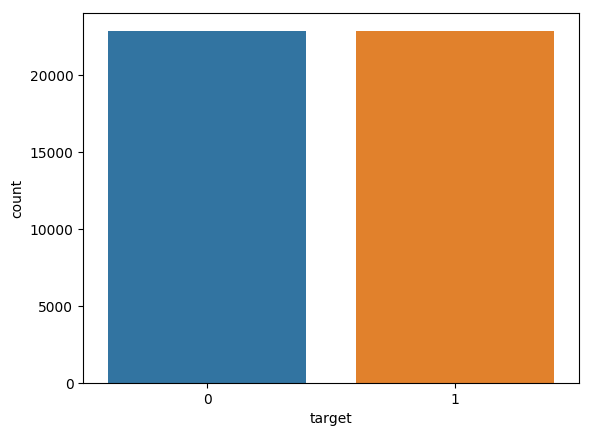

In [75]:

display(sns.countplot(x=target, data=under_sample).figure)

In [76]:
X = under_sample.loc[:, df.columns!=target]
Y = under_sample.loc[:, df.columns==target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
clf = LogisticRegression().fit(X_train, Y_train)
Y_Test_Pred = clf.predict(X_test)

/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 return f(**kwargs)
/local_disk0/pythonVirtualEnvDirs/virtualEnv-f32bc380-646a-4acd-87ff-b578fc748500/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

In [77]:
generate_model_report(Y_test, Y_Test_Pred)

Accuracy = 0.6791079346171663
Precision = 0.6861659011078087
Recall = 0.6678500986193294
F1 Score = 0.676884120743653

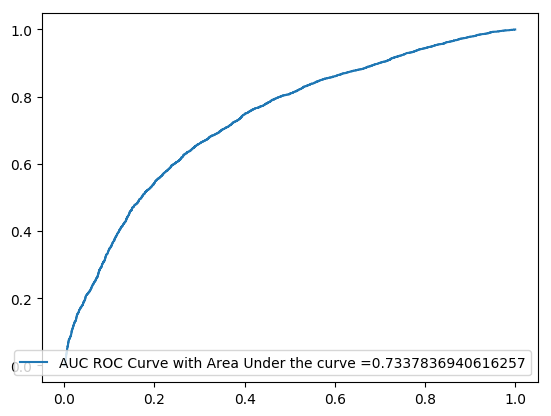

In [78]:
display(generate_auc_roc_curve(clf, X_test))

# MULTICLASS DATA BALANCING

In [ ]:
#Spliting dataset to training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=123)

In [ ]:
#Encoding wine categories. We have three categories and this will change the categories to 0,1, and 2.
labelencoder_y =LabelEncoder()
y= labelencoder_y.fit_transform(y)

In [ ]:
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
#Scaling the data
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
print('X_train Shape:',X_train.shape ,'\nX_test Shape:',X_test.shape,'\ny_train Shape:',y_train.shape ,'\ny_test Shape:',y_test.shape )

In [ ]:
from imblearn.datasets import make_imbalance

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

print(__doc__)


def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')

In [ ]:
sampling_strategy = 'not minority'

rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)
print('Information of the diff data set after making it '
      'balanced by under-sampling: \n sampling_strategy={} \n y: {}'
      .format(sampling_strategy, Counter(y_res)))
plot_pie(y_res)

sampling_strategy = 'not majority'

ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_res, y_res = ros.fit_resample(X, y)
print('Information of the Diff data set after making it '
      'balanced by over-sampling: \n sampling_strategy={} \n y: {}'
      .format(sampling_strategy, Counter(y_res)))
plot_pie(y_res)